In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2
from concurrent import futures
import threading
import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from keras.applications.xception import Xception
import time
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
date_string = time.strftime("%Y-%m-%d-%H")



Using TensorFlow backend.


In [2]:
base_dir = "/mnt/efs/tianyi/malaria/cell_images"
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)



np.random.seed(15)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42, replace = False).reset_index(drop=True)

print(files_df.head())


train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.2, random_state=42)

print(train_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nTest:', Counter(test_labels))


def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

# reshape the image into 125x125, based on the max dim 

IMG_DIMS = (125,125)

                                            filename    label
0  /mnt/efs/tianyi/malaria/cell_images/Parasitize...  malaria
1  /mnt/efs/tianyi/malaria/cell_images/Parasitize...  malaria
2  /mnt/efs/tianyi/malaria/cell_images/Uninfected...  healthy
3  /mnt/efs/tianyi/malaria/cell_images/Uninfected...  healthy
4  /mnt/efs/tianyi/malaria/cell_images/Uninfected...  healthy
(22046,) (5512,)
Train: Counter({'healthy': 11066, 'malaria': 10980}) 
Test: Counter({'malaria': 2799, 'healthy': 2713})
Starting Img shape computation:
Thread-4: working on img num: 0
Thread-24: working on img num: 5000
Thread-33: working on img num: 10000
Thread-6: working on img num: 15000
Thread-5: working on img num: 20000
Thread-11: working on img num: 22045
Min Dimensions: [46 46  3]
Avg Dimensions: [132.86419305 132.45405062   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 394   3]


In [3]:
def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))


print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

print(train_data.shape, test_data.shape)



Loading Train Images:
Thread-44: working on img num: 0
Thread-66: working on img num: 5000
Thread-74: working on img num: 10000
Thread-55: working on img num: 15000
Thread-62: working on img num: 20000
Thread-49: working on img num: 22045

Loading Test Images:
Thread-47: working on img num: 0
Thread-59: working on img num: 5000
Thread-44: working on img num: 5511
(22046, 125, 125, 3) (5512, 125, 125, 3)


In [4]:
le = LabelEncoder()
le.fit(train_labels)
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

print(train_labels[:6], y_train[:6])

x_train = train_data
x_test = test_data


['healthy' 'healthy' 'healthy' 'malaria' 'healthy' 'malaria'] [0 0 0 1 0 1]


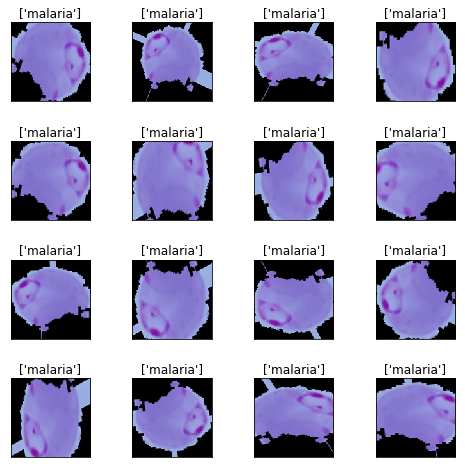

In [5]:
batch_size = 32


# data augmentation
# this is the augmentation configuration we will use for training


%matplotlib inline
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=1.0,
        height_shift_range=1.0,
        rotation_range=30,
        validation_split=0.2)
train_datagen.fit(x_train)



plt.figure(1 , figsize = (8 , 8))
n = 1222 
m = 0
sample_generator = train_datagen.flow(x_train[n:n+1], train_labels[n:n+1],
                                      batch_size=1)
for i in range(16):
    m += 1
    sample = next(sample_generator)
    plt.subplot(4, 4, m)
    plt.imshow(sample[0][0])
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.xticks([]) , plt.yticks([])
    plt.title('{}'.format(sample[1]))
plt.show()


In [6]:
from keras.applications.xception import Xception
# load model
model = Xception


base_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)
#print(base_model.summary())



In [7]:
model = Model(inputs = base_model.input, outputs = predictions)


In [8]:
# freeze layers before 99
for layer in model.layers[:99]:
    layer.trainable = False
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

# unfreeze layers after 99
for layer in model.layers[99:]:
    layer.trainable = True

# compile model
model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ["accuracy"]
)


# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1
)

In [ ]:
hist = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size, subset='training'),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=15,
                    validation_data=train_datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation'),
                    validation_steps=x_train.shape[0]*0.2 // batch_size,
                    callbacks=[early_stopping, reduce_lr], shuffle = True,
                    verbose = 1)


model.save('xception_15epoch.h5')

Epoch 1/15
688/688 [==============================] - 1734s 3s/step - loss: 0.1900 - accuracy: 0.9366 - val_loss: 0.0127 - val_accuracy: 0.9646
Epoch 2/15
688/688 [==============================] - 1703s 2s/step - loss: 0.1301 - accuracy: 0.9567 - val_loss: 0.1872 - val_accuracy: 0.9607
Epoch 3/15
688/688 [==============================] - 1705s 2s/step - loss: 0.1218 - accuracy: 0.9589 - val_loss: 0.0084 - val_accuracy: 0.9701
Epoch 4/15
688/688 [==============================] - 1695s 2s/step - loss: 0.1117 - accuracy: 0.9614 - val_loss: 0.0947 - val_accuracy: 0.9701
Epoch 5/15
688/688 [==============================] - 1697s 2s/step - loss: 0.1065 - accuracy: 0.9631 - val_loss: 0.0818 - val_accuracy: 0.9680
Epoch 6/15
144/688 [=====>........................] - ETA: 21:13 - loss: 0.0906 - accuracy: 0.9720

In [ ]:
x_test_scaled = x_test / 255

score = model.evaluate(x_test_scaled, y_test, verbose = 1)
print("evaluate loss: {[0]:.4f}".format(score))
print("evaluate acc: {[1]:.1%}".format(score))

xception_preds = model.predict(x_test_scaled, batch_size=32)
xception_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                   for pred in xception_preds.ravel()])


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Xception Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(hist.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()


In [10]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, xception_preds)
auc_keras = auc(fpr_keras, tpr_keras)

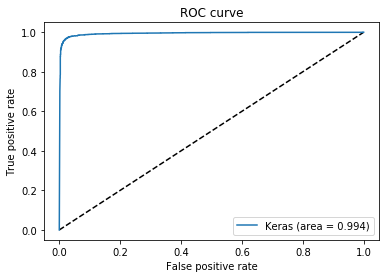

In [11]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Xception Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(hist.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()


In [ ]:
def cm_analysis(y_true, y_pred, lab, actual_lab, date_string, ymap=None, figsize=(5,5)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        lab = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=lab)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=actual_lab, columns=actual_lab)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
   


preds = []
for pred in xception_preds.ravel():
    if pred > 0.5:
        l = 1
    else:
        l = 0
    preds.append(l)


lab = [0,1]
act_lab = ['healthy', 'malaria']

cm_analysis(y_test, preds, lab, act_lab, date_string)

